# Mini-Projekt: Zmodyfikowany Gridworld 7x7

## Autor: Mikołaj Skałka

## 1. Setup - importy i funkcje pomocnicze

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Ustawienia wyświetlania
np.set_printoptions(precision=2, suppress=True)

In [4]:
def evaluate_policy_linear_system(P_pi: np.ndarray, r_pi: np.ndarray, gamma: float) -> np.ndarray:
    """Rozwiązuje równanie Bellmana dla danej polityki w postaci macierzowej.

    Dla polityki pi mamy:
        v = r_pi + gamma * P_pi * v
    czyli:
        (I - gamma * P_pi) v = r_pi

    Zwraca wektor v (shape: [nS]).
    """
    nS = P_pi.shape[0]
    I = np.eye(nS)
    return np.linalg.solve(I - gamma * P_pi, r_pi)


def build_P_r_for_policy(P, pi):
    """
    Buduje (P_pi, r_pi) dla zadanej polityki π.

    Wejście:
    - P: model środowiska w formacie P[s][a] -> lista (p, s2, r, terminated)
    - pi: polityka stochastyczna w postaci macierzy (nS, nA)

    Wyjście:
    - P_pi: macierz przejść dla polityki π (nS x nS)
    - r_pi: wektor nagród oczekiwanych dla polityki π (nS,)
    """
    nS = len(P)
    nA = len(P[0])

    P_pi = np.zeros((nS, nS), dtype=float)
    r_pi = np.zeros(nS, dtype=float)

    for s in range(nS):
        for a in range(nA):
            w = float(pi[s, a])
            if w == 0.0:
                continue
            outcomes = P[s][a]
            if not outcomes:
                continue
            for (p, s2, r, terminated) in outcomes:
                r_pi[s] += w * p * float(r)
                if not terminated:
                    P_pi[s, int(s2)] += w * p

    return P_pi, r_pi

## 2. Definicja zmodyfikowanego środowiska Gridworld 7x7

### Opis środowiska

Nasze zmodyfikowane środowisko to siatka **7x7** (49 stanów) z następującymi cechami:

#### Akcje (część agenta)
- `0 = UP` (↑) - ruch w górę
- `1 = RIGHT` (→) - ruch w prawo  
- `2 = DOWN` (↓) - ruch w dół
- `3 = LEFT` (←) - ruch w lewo

#### Dynamika środowiska (część środowiska)
- **Normalny ruch**: przejście do sąsiedniego pola z nagrodą 0
- **Wyjście poza planszę**: agent zostaje w miejscu, nagroda -1
- **Teleporty (punkty specjalne)**: niezależnie od wybranej akcji, agent jest przenoszony do innego miejsca z określoną nagrodą

#### Punkty specjalne (teleporty)

| Punkt | Pozycja źródłowa | Pozycja docelowa | Nagroda | Opis |
|-------|-----------------|------------------|---------|------|
| **A** | (0,1) | (6,1) | +15 | Wysoka nagroda, teleport na dół planszy |
| **B** | (0,5) | (3,3) | +10 | Średnia nagroda, teleport do centrum |
| **C** | (3,0) | (3,6) | +8 | Przejście przez środek planszy |
| **D** | (6,3) | (0,3) | +12 | Teleport z dołu na górę planszy |

### Wizualizacja siatki

```
    0   1   2   3   4   5   6
  +---+---+---+---+---+---+---+
0 |   | A |   |D' |   | B |   |
  +---+---+---+---+---+---+---+
1 |   |   |   |   |   |   |   |
  +---+---+---+---+---+---+---+
2 |   |   |   |   |   |   |   |
  +---+---+---+---+---+---+---+
3 | C |   |   |B' |   |   |C' |
  +---+---+---+---+---+---+---+
4 |   |   |   |   |   |   |   |
  +---+---+---+---+---+---+---+
5 |   |   |   |   |   |   |   |
  +---+---+---+---+---+---+---+
6 |   |A' |   | D |   |   |   |
  +---+---+---+---+---+---+---+
```

Gdzie:
- A, B, C, D - punkty źródłowe teleportów
- A', B', C', D' - punkty docelowe teleportów

In [5]:
def build_gridworld_7x7_P():
    """
    Buduje model MDP dla zmodyfikowanego Gridworld 7x7.
    
    Środowisko zawiera 4 punkty specjalne (teleporty) z różnymi nagrodami,
    rozmieszczone strategicznie po całej planszy.
    
    Returns:
        P: dict - model przejść P[s][a] -> [(p, s2, r, terminated)]
        nS: int - liczba stanów (49)
        nA: int - liczba akcji (4)
        nrow: int - liczba wierszy (7)
        ncol: int - liczba kolumn (7)
        special_points: dict - informacje o punktach specjalnych
    """
    nrow, ncol = 7, 7
    nS, nA = nrow * ncol, 4
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}
    
    # Definicja punktów specjalnych (teleportów)
    # Format: (źródło, cel, nagroda)
    special_points = {
        'A': {'source': (0, 1), 'target': (6, 1), 'reward': 15.0},
        'B': {'source': (0, 5), 'target': (3, 3), 'reward': 10.0},
        'C': {'source': (3, 0), 'target': (3, 6), 'reward': 8.0},
        'D': {'source': (6, 3), 'target': (0, 3), 'reward': 12.0},
    }
    
    # Mapowanie pozycji źródłowych na (cel, nagroda)
    teleports = {}
    for name, info in special_points.items():
        teleports[info['source']] = (info['target'], info['reward'])
    
    # Funkcje pomocnicze
    def s2pos(s):
        """Konwersja indeksu stanu na pozycję (wiersz, kolumna)"""
        return (s // ncol, s % ncol)
    
    def pos2s(r, c):
        """Konwersja pozycji (wiersz, kolumna) na indeks stanu"""
        return r * ncol + c
    
    # Wektory ruchu dla każdej akcji
    # UP=0, RIGHT=1, DOWN=2, LEFT=3
    moves = {
        0: (-1, 0),  # UP
        1: (0, 1),   # RIGHT
        2: (1, 0),   # DOWN
        3: (0, -1)   # LEFT
    }
    
    # Budowanie modelu przejść
    for s in range(nS):
        r, c = s2pos(s)
        
        # Sprawdzenie czy jesteśmy na polu teleportu
        if (r, c) in teleports:
            target_pos, reward = teleports[(r, c)]
            s2 = pos2s(*target_pos)
            # Teleport działa niezależnie od wybranej akcji
            for a in range(nA):
                P[s][a] = [(1.0, s2, reward, False)]
            continue
        
        # Standardowe ruchy
        for a in range(nA):
            dr, dc = moves[a]
            r2, c2 = r + dr, c + dc
            
            # Sprawdzenie czy ruch wychodzi poza planszę
            if r2 < 0 or r2 >= nrow or c2 < 0 or c2 >= ncol:
                # Zostajemy w miejscu, kara -1
                s2 = s
                reward = -1.0
            else:
                # Normalny ruch, nagroda 0
                s2 = pos2s(r2, c2)
                reward = 0.0
            
            P[s][a] = [(1.0, s2, reward, False)]
    
    return P, nS, nA, nrow, ncol, special_points


# Budujemy środowisko
P, nS, nA, nrow, ncol, special_points = build_gridworld_7x7_P()

print(f"Rozmiar siatki: {nrow}x{ncol}")
print(f"Liczba stanów: {nS}")
print(f"Liczba akcji: {nA}")
print(f"\nPunkty specjalne (teleporty):")
for name, info in special_points.items():
    print(f"  {name}: {info['source']} → {info['target']} (nagroda: +{info['reward']})")

Rozmiar siatki: 7x7
Liczba stanów: 49
Liczba akcji: 4

Punkty specjalne (teleporty):
  A: (0, 1) → (6, 1) (nagroda: +15.0)
  B: (0, 5) → (3, 3) (nagroda: +10.0)
  C: (3, 0) → (3, 6) (nagroda: +8.0)
  D: (6, 3) → (0, 3) (nagroda: +12.0)


In [6]:
# Testy poprawności modelu

def pos2s(r, c, ncol=7):
    return r * ncol + c

# Test 1: Sprawdzenie rozmiaru
assert nS == 49, f"Oczekiwano 49 stanów, otrzymano {nS}"
assert nA == 4, f"Oczekiwano 4 akcji, otrzymano {nA}"

# Test 2: Sprawdzenie teleportów
sA = pos2s(0, 1)  # Punkt A
sA_target = pos2s(6, 1)  # Cel A'
for a in range(nA):
    assert P[sA][a] == [(1.0, sA_target, 15.0, False)], f"Teleport A nie działa dla akcji {a}"

sD = pos2s(6, 3)  # Punkt D
sD_target = pos2s(0, 3)  # Cel D'
for a in range(nA):
    assert P[sD][a] == [(1.0, sD_target, 12.0, False)], f"Teleport D nie działa dla akcji {a}"

# Test 3: Sprawdzenie kary za wyjście poza planszę
s00 = pos2s(0, 0)  # Lewy górny róg
UP, LEFT = 0, 3
assert P[s00][UP] == [(1.0, s00, -1.0, False)], "Kara za wyjście w górę nie działa"
assert P[s00][LEFT] == [(1.0, s00, -1.0, False)], "Kara za wyjście w lewo nie działa"

# Test 4: Sprawdzenie normalnego ruchu
s22 = pos2s(2, 2)  # Środek planszy
RIGHT = 1
s23 = pos2s(2, 3)
assert P[s22][RIGHT] == [(1.0, s23, 0.0, False)], "Normalny ruch nie działa"

print("✅ Wszystkie testy przeszły pomyślnie!")

✅ Wszystkie testy przeszły pomyślnie!


## 3. Ewaluacja polityki równoprawdopodobnej (losowej)

### Co to jest polityka równoprawdopodobna?

Polityka równoprawdopodobna (equiprobable random policy) to polityka, w której agent w każdym stanie wybiera każdą dostępną akcję z jednakowym prawdopodobieństwem.

W naszym przypadku: $\pi(a|s) = 0.25$ dla każdej akcji $a \in \{UP, RIGHT, DOWN, LEFT\}$

### Jak liczymy funkcję wartości $v_\pi$?

Funkcja wartości dla polityki $\pi$ jest zdefiniowana jako:

$$v_\pi(s) = \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t R_{t+1} \mid S_0 = s\right]$$

Rozwiązujemy ją przez układ równań Bellmana:

$$v_\pi = r_\pi + \gamma P_\pi v_\pi$$

Co przekształcamy do:

$$(I - \gamma P_\pi) v_\pi = r_\pi$$

In [7]:
# Parametry
gamma = 0.9  # Współczynnik dyskontowania

# Polityka równoprawdopodobna: każda akcja ma prawdopodobieństwo 1/4
pi_random = np.ones((nS, nA), dtype=float) / nA

print("Polityka równoprawdopodobna (przykład dla stanu 0):")
print(f"  π(UP|s=0) = {pi_random[0, 0]:.2f}")
print(f"  π(RIGHT|s=0) = {pi_random[0, 1]:.2f}")
print(f"  π(DOWN|s=0) = {pi_random[0, 2]:.2f}")
print(f"  π(LEFT|s=0) = {pi_random[0, 3]:.2f}")
print(f"  Suma: {pi_random[0].sum():.2f}")

Polityka równoprawdopodobna (przykład dla stanu 0):
  π(UP|s=0) = 0.25
  π(RIGHT|s=0) = 0.25
  π(DOWN|s=0) = 0.25
  π(LEFT|s=0) = 0.25
  Suma: 1.00


In [8]:
# Budujemy model przejść i nagród dla polityki losowej
P_pi_random, r_pi_random = build_P_r_for_policy(P, pi_random)

# Rozwiązujemy równanie Bellmana
v_pi_random = evaluate_policy_linear_system(P_pi_random, r_pi_random, gamma)

# Wyświetlamy wyniki jako siatkę 7x7
print(f"Funkcja wartości v_π dla polityki losowej (γ = {gamma}):")
print("="*60)
v_grid = v_pi_random.reshape(nrow, ncol)
print(np.round(v_grid, 1))

Funkcja wartości v_π dla polityki losowej (γ = 0.9):
[[ 8.4 17.1  7.3  4.4  5.5 12.   5.2]
 [ 5.7  7.2  4.8  3.4  3.5  4.6  2.9]
 [ 5.   4.4  3.3  2.5  2.2  2.1  1.2]
 [ 8.4  4.2  2.8  2.2  1.7  1.2  0.4]
 [ 3.4  2.9  2.8  2.9  2.1  1.1  0.1]
 [ 1.6  2.4  3.9  5.9  3.4  1.4  0.1]
 [ 0.7  2.3  6.1 15.9  5.8  1.7 -0.2]]


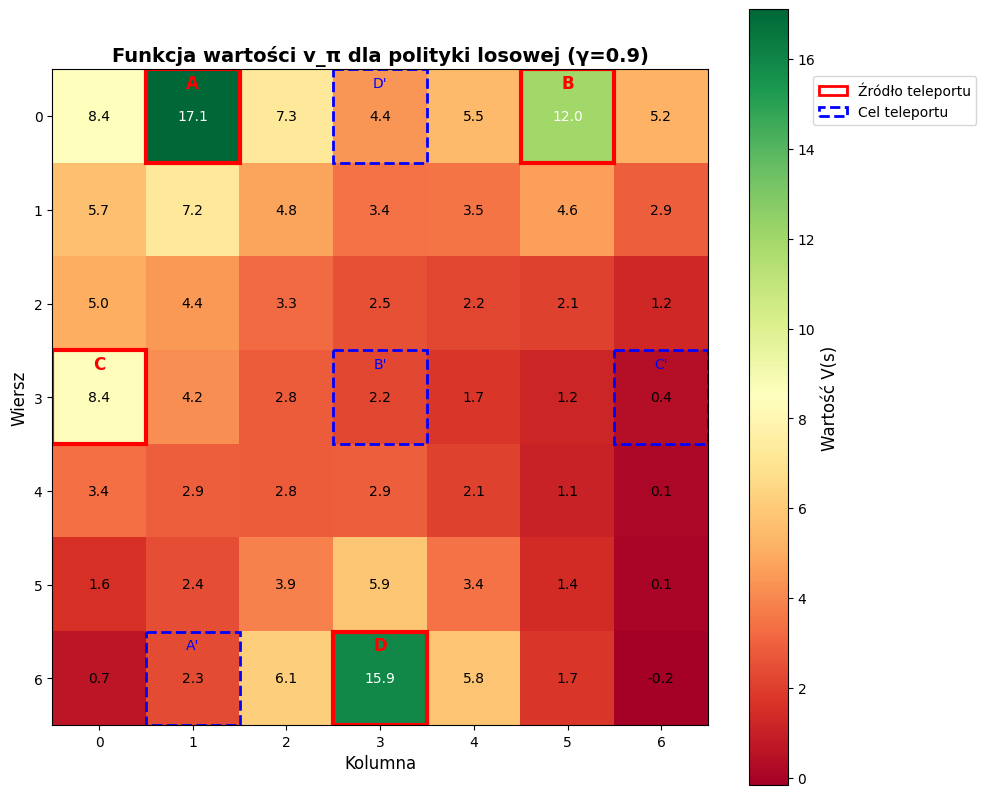

In [9]:
def visualize_values(v, nrow, ncol, special_points, title="Funkcja wartości"):
    """
    Wizualizacja funkcji wartości jako heatmapa z oznaczonymi punktami specjalnymi.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    v_grid = v.reshape(nrow, ncol)
    
    # Heatmapa
    cmap = plt.cm.RdYlGn  # Czerwony (niskie) -> Żółty -> Zielony (wysokie)
    im = ax.imshow(v_grid, cmap=cmap, aspect='equal')
    
    # Dodanie wartości liczbowych
    for i in range(nrow):
        for j in range(ncol):
            text = ax.text(j, i, f'{v_grid[i, j]:.1f}',
                          ha='center', va='center', fontsize=10,
                          color='black' if abs(v_grid[i, j]) < v_grid.max()/2 else 'white')
    
    # Oznaczenie punktów specjalnych
    for name, info in special_points.items():
        sr, sc = info['source']
        tr, tc = info['target']
        
        # Źródło - czerwona ramka
        rect = plt.Rectangle((sc-0.5, sr-0.5), 1, 1, fill=False, 
                             edgecolor='red', linewidth=3)
        ax.add_patch(rect)
        ax.text(sc, sr-0.35, name, ha='center', va='center', 
               fontsize=12, fontweight='bold', color='red')
        
        # Cel - niebieska ramka
        rect = plt.Rectangle((tc-0.5, tr-0.5), 1, 1, fill=False,
                             edgecolor='blue', linewidth=2, linestyle='--')
        ax.add_patch(rect)
        ax.text(tc, tr-0.35, f"{name}'", ha='center', va='center',
               fontsize=10, color='blue')
    
    # Formatowanie
    ax.set_xticks(range(ncol))
    ax.set_yticks(range(nrow))
    ax.set_xlabel('Kolumna', fontsize=12)
    ax.set_ylabel('Wiersz', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Wartość V(s)', fontsize=12)
    
    # Legenda
    red_patch = mpatches.Patch(facecolor='white', edgecolor='red', 
                               linewidth=2, label='Źródło teleportu')
    blue_patch = mpatches.Patch(facecolor='white', edgecolor='blue',
                                linewidth=2, linestyle='--', label='Cel teleportu')
    ax.legend(handles=[red_patch, blue_patch], loc='upper left', 
             bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    plt.show()
    
    return fig


# Wizualizacja
fig = visualize_values(v_pi_random, nrow, ncol, special_points,
                       title=f"Funkcja wartości v_π dla polityki losowej (γ={gamma})")

### Interpretacja wyników polityki losowej

**Obserwacje:**
1. Najwyższe wartości są w pobliżu punktów specjalnych (teleportów) z wysokimi nagrodami
2. Wartości maleją wraz z odległością od źródeł nagród
3. Rogi planszy mają niższe wartości (większe ryzyko kary -1 za wyjście poza planszę)
4. Efekt dyskontowania (γ=0.9) powoduje, że dalsze nagrody są mniej wartościowe

## 4. Obliczenie wartości optymalnej v* i polityki optymalnej π*

### Różnica między v_π a v*

- **v_π** - wartość dla konkretnej polityki π (uśredniamy po akcjach zgodnie z π)
- **v*** - wartość optymalna (wybieramy najlepszą akcję w każdym stanie)

Równanie optymalności Bellmana:

$$v_*(s) = \max_a \sum_{s', r} p(s', r | s, a) [r + \gamma v_*(s')]$$

### Algorytm Value Iteration

Iteracyjnie aktualizujemy wartości aż do zbieżności:

$$V_{k+1}(s) = \max_a \sum_{s', r} p(s', r | s, a) [r + \gamma V_k(s')]$$

In [10]:
def value_iteration(P, nS, nA, gamma=0.9, tol=1e-10, max_iter=100000):
    """
    Algorytm Value Iteration do znalezienia optymalnej funkcji wartości v*.
    
    Iteracyjnie stosujemy operator Bellmana z max po akcjach,
    aż do zbieżności.
    
    Returns:
        V: ndarray - optymalna funkcja wartości v*
        iterations: int - liczba iteracji do zbieżności
    """
    V = np.zeros(nS, dtype=float)
    
    for iteration in range(max_iter):
        delta = 0.0
        V_new = V.copy()
        
        for s in range(nS):
            best_value = None
            
            for a in range(nA):
                outcomes = P[s][a]
                if not outcomes:
                    continue
                
                # Obliczamy Q(s, a)
                q = 0.0
                for (p, s2, r, terminated) in outcomes:
                    q += p * (r + gamma * (0.0 if terminated else V[int(s2)]))
                
                # Wybieramy maksimum
                if best_value is None or q > best_value:
                    best_value = q
            
            V_new[s] = 0.0 if best_value is None else best_value
            delta = max(delta, abs(V_new[s] - V[s]))
        
        V = V_new
        
        if delta < tol:
            return V, iteration + 1
    
    return V, max_iter


def greedy_policy_from_V(P, nS, nA, V, gamma=0.9):
    """
    Wyznacza politykę zachłanną (greedy) względem funkcji wartości V.
    
    π*(s) = argmax_a Q(s, a)
    
    Returns:
        pi_det: ndarray - deterministyczna polityka (indeks najlepszej akcji dla każdego stanu)
    """
    pi_det = np.zeros(nS, dtype=int)
    
    for s in range(nS):
        best_a = 0
        best_q = None
        
        for a in range(nA):
            outcomes = P[s][a]
            if not outcomes:
                continue
            
            q = 0.0
            for (p, s2, r, terminated) in outcomes:
                q += p * (r + gamma * (0.0 if terminated else V[int(s2)]))
            
            if best_q is None or q > best_q:
                best_q = q
                best_a = a
        
        pi_det[s] = best_a
    
    return pi_det

In [11]:
# Obliczamy optymalną funkcję wartości
V_star, iterations = value_iteration(P, nS, nA, gamma=gamma)

print(f"Value Iteration zbiegło po {iterations} iteracjach")
print(f"\nOptymalna funkcja wartości v* (γ = {gamma}):")
print("="*60)
V_star_grid = V_star.reshape(nrow, ncol)
print(np.round(V_star_grid, 1))

Value Iteration zbiegło po 246 iteracjach

Optymalna funkcja wartości v* (γ = 0.9):
[[45.6 50.7 45.6 41.1 37.9 42.1 37.9]
 [41.1 45.6 41.1 36.9 34.1 37.9 34.1]
 [36.9 41.1 36.9 33.3 30.7 34.1 30.7]
 [32.9 36.9 33.3 35.7 32.1 30.7 27.6]
 [29.9 33.3 35.7 39.6 35.7 32.1 28.9]
 [32.1 35.7 39.6 44.1 39.6 35.7 32.1]
 [35.7 39.6 44.1 48.9 44.1 39.6 35.7]]


In [12]:
# Wyznaczamy politykę optymalną
pi_star = greedy_policy_from_V(P, nS, nA, V_star, gamma=gamma)

# Wizualizacja polityki jako strzałki
def action_arrows_grid(pi_det, nrow, ncol):
    """Zamienia deterministyczną politykę na siatkę strzałek."""
    arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    grid = []
    for r in range(nrow):
        row = []
        for c in range(ncol):
            s = r * ncol + c
            row.append(arrows[pi_det[s]])
        grid.append(' '.join(row))
    return '\n'.join(grid)

print("Polityka optymalna π* (strzałki):")
print("="*30)
print(action_arrows_grid(pi_star, nrow, ncol))

Polityka optymalna π* (strzałki):
→ ↑ ← ← → ↑ ←
↑ ↑ ↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↓ ↓ ↑ ↑
→ ↑ → ↓ ↓ ↓ ↓
→ → → ↓ ↓ ↓ ↓
→ → → ↑ ← ← ←


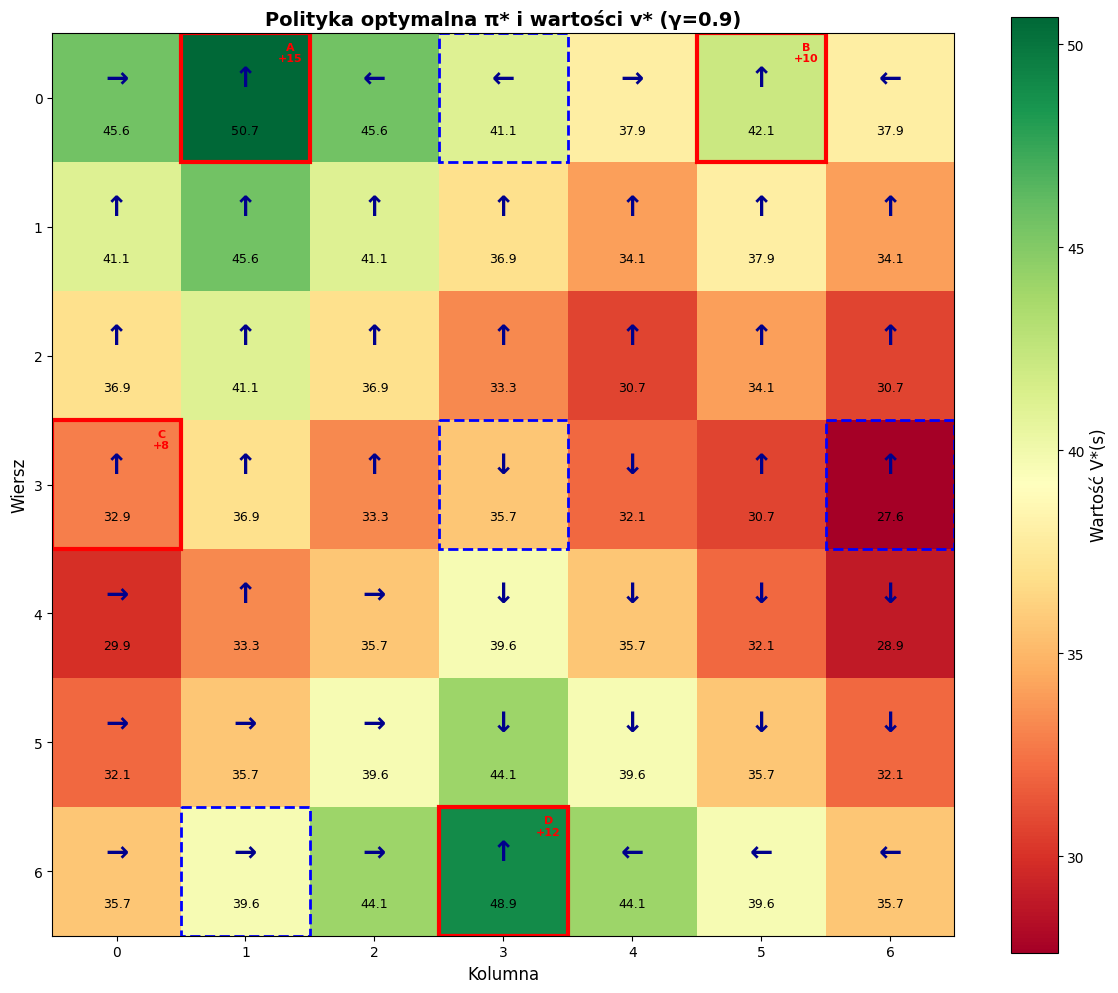

In [13]:
def visualize_policy_and_values(V, pi_det, nrow, ncol, special_points, title="Polityka optymalna i wartości"):
    """
    Wizualizacja polityki optymalnej (strzałki) nałożonej na heatmapę wartości.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    
    V_grid = V.reshape(nrow, ncol)
    
    # Heatmapa wartości
    cmap = plt.cm.RdYlGn
    im = ax.imshow(V_grid, cmap=cmap, aspect='equal')
    
    # Strzałki dla polityki
    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)}  # (dx, dy)
    arrow_symbols = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    
    for i in range(nrow):
        for j in range(ncol):
            s = i * ncol + j
            a = pi_det[s]
            
            # Wartość liczbowa
            ax.text(j, i + 0.25, f'{V_grid[i, j]:.1f}',
                   ha='center', va='center', fontsize=9,
                   color='black')
            
            # Strzałka
            ax.text(j, i - 0.15, arrow_symbols[a],
                   ha='center', va='center', fontsize=20,
                   color='darkblue', fontweight='bold')
    
    # Oznaczenie punktów specjalnych
    for name, info in special_points.items():
        sr, sc = info['source']
        tr, tc = info['target']
        reward = info['reward']
        
        # Źródło
        rect = plt.Rectangle((sc-0.5, sr-0.5), 1, 1, fill=False,
                             edgecolor='red', linewidth=3)
        ax.add_patch(rect)
        ax.text(sc + 0.35, sr - 0.35, f"{name}\n+{int(reward)}", 
               ha='center', va='center', fontsize=8, color='red', fontweight='bold')
        
        # Cel
        rect = plt.Rectangle((tc-0.5, tr-0.5), 1, 1, fill=False,
                             edgecolor='blue', linewidth=2, linestyle='--')
        ax.add_patch(rect)
    
    # Formatowanie
    ax.set_xticks(range(ncol))
    ax.set_yticks(range(nrow))
    ax.set_xlabel('Kolumna', fontsize=12)
    ax.set_ylabel('Wiersz', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Wartość V*(s)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig


# Wizualizacja
fig = visualize_policy_and_values(V_star, pi_star, nrow, ncol, special_points,
                                   title=f"Polityka optymalna π* i wartości v* (γ={gamma})")

## 5. Porównanie polityki losowej i optymalnej

In [14]:
# Porównanie wartości
print("Porównanie funkcji wartości:")
print("="*60)
print(f"\n{'Stan':<15} {'v_π (losowa)':<15} {'v* (optymalna)':<15} {'Różnica':<15}")
print("-"*60)

# Wybrane stany do porównania
interesting_states = [
    (0, 0, "Róg (0,0)"),
    (0, 1, "Teleport A"),
    (0, 5, "Teleport B"),
    (3, 0, "Teleport C"),
    (3, 3, "Centrum (B')"),
    (6, 3, "Teleport D"),
    (6, 6, "Róg (6,6)"),
]

for r, c, name in interesting_states:
    s = r * ncol + c
    v_random = v_pi_random[s]
    v_opt = V_star[s]
    diff = v_opt - v_random
    print(f"{name:<15} {v_random:>12.2f}   {v_opt:>12.2f}   {diff:>+12.2f}")

print("\n" + "="*60)
print(f"Średnia wartość (losowa):   {v_pi_random.mean():.2f}")
print(f"Średnia wartość (optymalna): {V_star.mean():.2f}")
print(f"Poprawa średnia:             {(V_star.mean() - v_pi_random.mean()):.2f}")

Porównanie funkcji wartości:

Stan            v_π (losowa)    v* (optymalna)  Różnica        
------------------------------------------------------------
Róg (0,0)               8.41          45.61         +37.20
Teleport A             17.11          50.68         +33.57
Teleport B             12.02          42.11         +30.09
Teleport C              8.39          32.87         +24.48
Centrum (B')            2.24          35.68         +33.44
Teleport D             15.94          48.95         +33.01
Róg (6,6)              -0.17          35.68         +35.86

Średnia wartość (losowa):   4.08
Średnia wartość (optymalna): 37.28
Poprawa średnia:             33.19


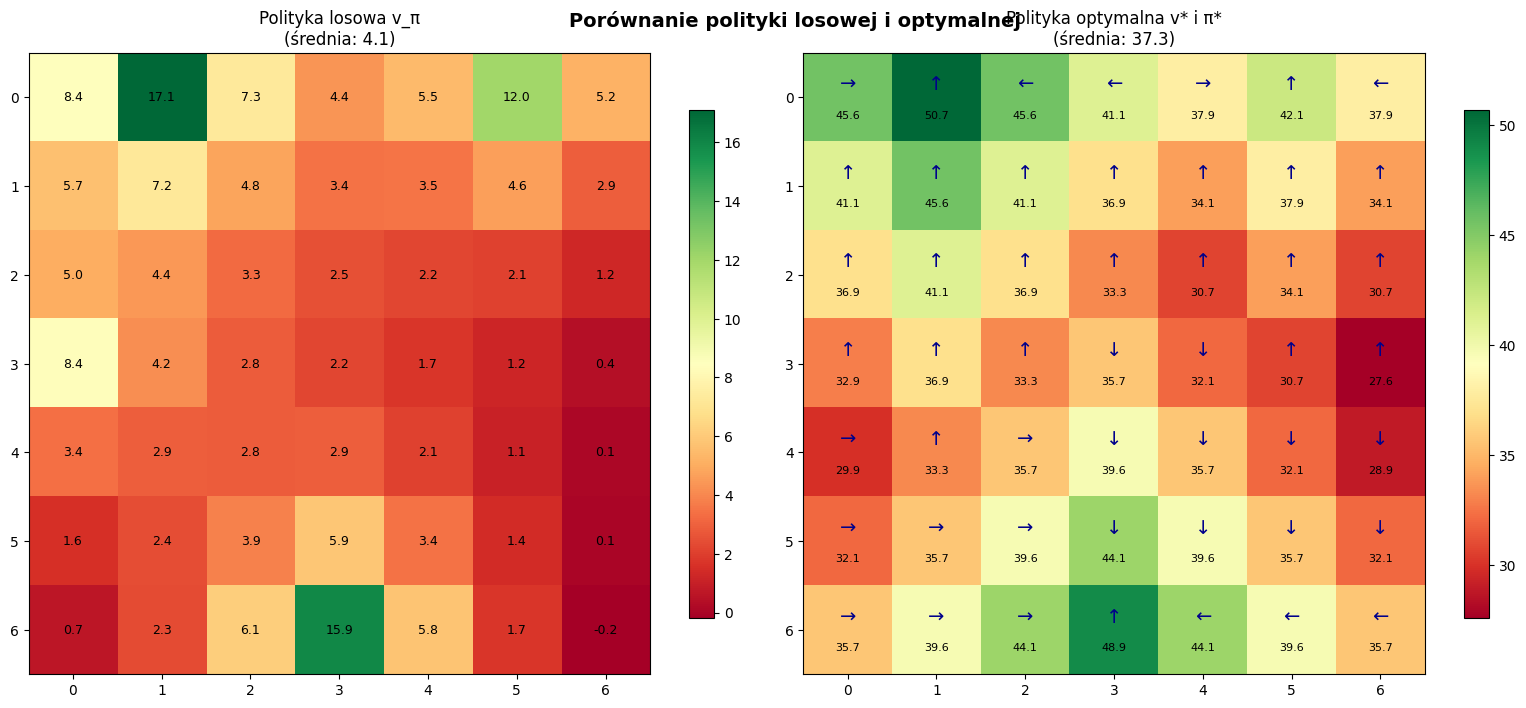

In [15]:
# Wizualizacja porównawcza
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Polityka losowa
ax1 = axes[0]
v_grid_random = v_pi_random.reshape(nrow, ncol)
im1 = ax1.imshow(v_grid_random, cmap='RdYlGn', aspect='equal')
for i in range(nrow):
    for j in range(ncol):
        ax1.text(j, i, f'{v_grid_random[i, j]:.1f}',
                ha='center', va='center', fontsize=9)
ax1.set_title(f'Polityka losowa v_π\n(średnia: {v_pi_random.mean():.1f})', fontsize=12)
ax1.set_xticks(range(ncol))
ax1.set_yticks(range(nrow))
plt.colorbar(im1, ax=ax1, shrink=0.8)

# Polityka optymalna
ax2 = axes[1]
V_star_grid = V_star.reshape(nrow, ncol)
im2 = ax2.imshow(V_star_grid, cmap='RdYlGn', aspect='equal')
arrow_symbols = {0: '↑', 1: '→', 2: '↓', 3: '←'}
for i in range(nrow):
    for j in range(ncol):
        s = i * ncol + j
        ax2.text(j, i + 0.2, f'{V_star_grid[i, j]:.1f}',
                ha='center', va='center', fontsize=8)
        ax2.text(j, i - 0.15, arrow_symbols[pi_star[s]],
                ha='center', va='center', fontsize=14, color='darkblue')
ax2.set_title(f'Polityka optymalna v* i π*\n(średnia: {V_star.mean():.1f})', fontsize=12)
ax2.set_xticks(range(ncol))
ax2.set_yticks(range(nrow))
plt.colorbar(im2, ax=ax2, shrink=0.8)

plt.suptitle('Porównanie polityki losowej i optymalnej', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Analiza i interpretacja wyników

### Obserwacje dotyczące polityki optymalnej

1. **Strzałki kierują się w stronę najbliższego teleportu z wysoką nagrodą**
   - W górnej części planszy strzałki kierują się do A (+15) lub B (+10)
   - W dolnej części planszy strzałki kierują się do D (+12)

2. **Efekt "basenu przyciągania"**
   - Każdy teleport tworzy wokół siebie obszar, z którego optymalna polityka prowadzi właśnie do niego
   - Granice tych obszarów zależą od wartości nagród i odległości

3. **Wartości na teleportach**
   - Teleporty mają wysokie wartości, bo gwarantują natychmiastową nagrodę
   - Ale wartość zależy też od tego, gdzie teleport nas przenosi!

### Dlaczego polityka optymalna jest lepsza?

- Polityka losowa "marnuje" ruchy, idąc czasem w złym kierunku
- Polityka optymalna zawsze wybiera najkrótszą drogę do najbardziej wartościowego celu
- Różnica jest szczególnie widoczna daleko od teleportów

## 7. Eksperymenty z parametrami

### Wpływ współczynnika dyskontowania γ

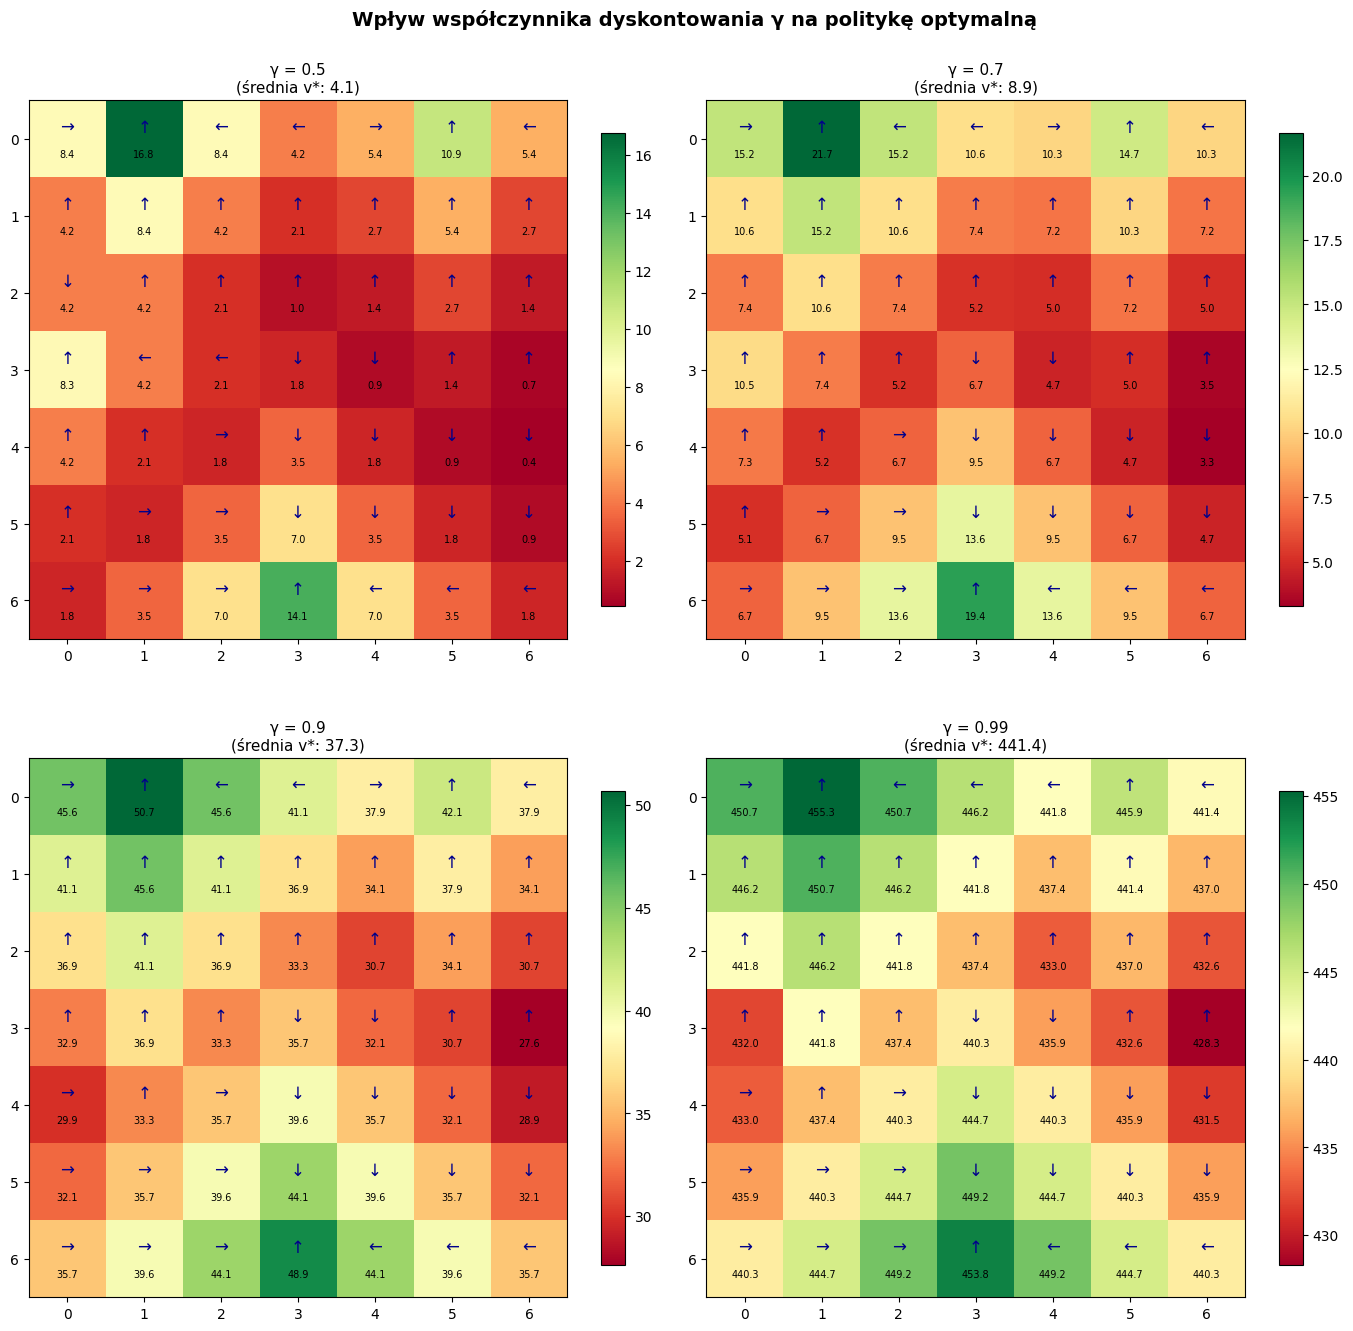

In [16]:
# Badanie wpływu gamma na politykę optymalną
gamma_values = [0.5, 0.7, 0.9, 0.99]

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, g in enumerate(gamma_values):
    V_g, _ = value_iteration(P, nS, nA, gamma=g)
    pi_g = greedy_policy_from_V(P, nS, nA, V_g, gamma=g)
    
    ax = axes[idx]
    V_grid = V_g.reshape(nrow, ncol)
    im = ax.imshow(V_grid, cmap='RdYlGn', aspect='equal')
    
    arrow_symbols = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    for i in range(nrow):
        for j in range(ncol):
            s = i * ncol + j
            ax.text(j, i + 0.2, f'{V_grid[i, j]:.1f}',
                   ha='center', va='center', fontsize=7)
            ax.text(j, i - 0.15, arrow_symbols[pi_g[s]],
                   ha='center', va='center', fontsize=12, color='darkblue')
    
    ax.set_title(f'γ = {g}\n(średnia v*: {V_g.mean():.1f})', fontsize=11)
    ax.set_xticks(range(ncol))
    ax.set_yticks(range(nrow))
    plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle('Wpływ współczynnika dyskontowania γ na politykę optymalną', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretacja wpływu γ

- **Niskie γ (0.5)**: Agent jest "krótkowzroczny", preferuje najbliższe nagrody
- **Wysokie γ (0.99)**: Agent planuje długoterminowo, wartości są wyższe
- **Zmiana polityki**: Przy niskim γ agent może preferować bliższy, ale mniej wartościowy teleport

## 8. Podsumowanie

### Co zostało zrobione?

1. **Zbudowano zmodyfikowane środowisko Gridworld 7x7** z 4 punktami specjalnymi (teleportami)
2. **Przeprowadzono ewaluację polityki losowej** - obliczono v_π
3. **Znaleziono politykę optymalną** π* i wartość optymalną v* metodą Value Iteration
4. **Porównano obie polityki** i zinterpretowano różnice
5. **Zbadano wpływ parametru γ** na politykę optymalną

### Kluczowe wnioski

| Aspekt | Polityka losowa | Polityka optymalna |
|--------|-----------------|-------------------|
| Wybór akcji | Losowy (25% każda) | Deterministyczny (najlepsza) |
| Średnia wartość | Niska | Wysoka |
| Interpretacja | "Błądzenie" | "Celowe dążenie" |

### Rozróżnienie Agent vs Środowisko

**Środowisko (Environment):**
- Siatka 7x7
- Reguły ruchu (deterministyczne)
- Teleporty i ich nagrody
- Kara za wyjście poza planszę

**Agent:**
- Polityka π (reguła wyboru akcji)
- Funkcja wartości V (ocena stanów)
- Cel: maksymalizacja zdyskontowanej sumy nagród

In [17]:
# Końcowe podsumowanie liczbowe
print("="*60)
print("PODSUMOWANIE PROJEKTU")
print("="*60)
print(f"\nŚrodowisko: Gridworld {nrow}x{ncol}")
print(f"Liczba stanów: {nS}")
print(f"Liczba akcji: {nA}")
print(f"Liczba teleportów: {len(special_points)}")
print(f"Współczynnik dyskontowania: γ = {gamma}")
print(f"\nWyniki:")
print(f"  Średnia v_π (losowa):    {v_pi_random.mean():.2f}")
print(f"  Średnia v* (optymalna):  {V_star.mean():.2f}")
print(f"  Poprawa:                 {((V_star.mean() - v_pi_random.mean()) / abs(v_pi_random.mean()) * 100):.1f}%")
print(f"\nIteracje Value Iteration: {iterations}")
print("="*60)

PODSUMOWANIE PROJEKTU

Środowisko: Gridworld 7x7
Liczba stanów: 49
Liczba akcji: 4
Liczba teleportów: 4
Współczynnik dyskontowania: γ = 0.9

Wyniki:
  Średnia v_π (losowa):    4.08
  Średnia v* (optymalna):  37.28
  Poprawa:                 813.2%

Iteracje Value Iteration: 246
